# Feature Extraction and Feature Descriptors Lab
## Traditional vs Deep Learning (TensorFlow)

### LAB OVERVIEW
In this lab, we will:
1.  **Understand Features:** Visualize edges and corners.
2.  **Traditional Methods:** Implement SIFT, HOG, and ORB with SVM.
3.  **The Failure:** Observe how traditional methods fail as complexity increases (**The Semantic Gap**).
4.  **The Solution:** Implement a **CNN using TensorFlow** to bridge that gap.
5.  **Comparison:** Prove that learned features outperform hand-crafted ones.

### DATASET: Caltech-256
We are using the **Caltech-256** dataset (via Kaggle).
- **Why?** It is harder than CIFAR/MNIST but smaller than ImageNet.
- **Challenge:** It has high intra-class variation (background clutter, rotations), making it perfect for demonstrating the Semantic Gap.

In [ ]:
# Install required packages
# !pip install opencv-python scikit-learn matplotlib seaborn tensorflow numpy pandas kagglehub

In [ ]:
# # Run this Cell if you didn't download the dataset.
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("jessicali9530/caltech256")

# print("Path to dataset files:", path)

In [ ]:
import shutil
import os

source_folder = "path/to/your/source_folder"  # Replace with the "Path to dataset files"
destination_folder = "path/to/your/destination_folder"  # Replace with the directory


if not os.path.exists(os.path.dirname(destination_folder)):
    os.makedirs(os.path.dirname(destination_folder))

shutil.move(source_folder, destination_folder)
print(f"Folder '{source_folder}' moved to '{destination_folder}'")

### Import the Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

# TensorFlow for CNN comparison
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.applications.vgg16 import preprocess_input

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")

2025-12-01 09:59:08.447117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764583148.660071      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764583148.716204      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✓ All libraries imported successfully!
TensorFlow version: 2.18.0
OpenCV version: 4.12.0


### PART 1: UNDERSTANDING FEATURES
**Concept Recap:**
Features are the "fingerprints" of an image.
* **Low-Level:** Edges, Corners (What we detect).
* **High-Level:** Objects, Concepts (What it means).

Let's visualize what the computer actually "sees" when we talk about features.

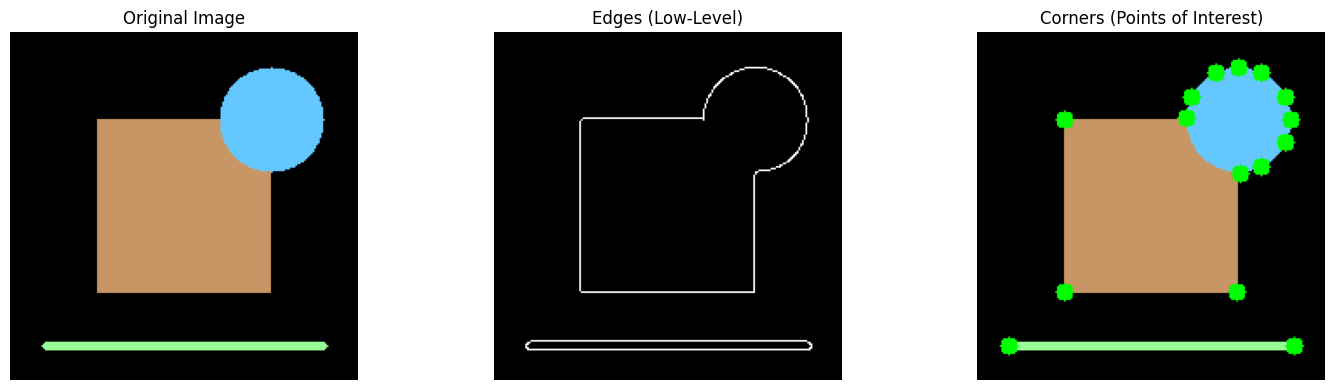

In [2]:
def visualize_features_concept():
    """Demonstrate what features are in an image"""
    # Create a simple synthetic image
    img = np.zeros((200, 200, 3), dtype=np.uint8)
    img[50:150, 50:150] = [100, 150, 200]  # square
    cv2.circle(img, (150, 50), 30, (255, 200, 100), -1)  # Circle
    cv2.line(img, (20, 180), (180, 180), (150, 255, 150), 3)  # Line
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect edges (Canny)
    edges = cv2.Canny(gray, 50, 150)
    
    # Detect corners (Harris/Shi-Tomasi)
    corners = cv2.goodFeaturesToTrack(gray, 25, 0.01, 10) # return maximum 25 corners; any corner quality score < 0.01 will be rejected; will not detect corners near 10 euclidean distance
    # Corner Shape: (N, 1, 2), where N is the number of corners found (up to 25)
    img_corners = img.copy()
    if corners is not None:
        for corner in corners:
            x, y = corner.ravel() # ravel will convert to 1D
            cv2.circle(img_corners, (int(x), int(y)), 5, (0, 255, 0), -1)
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Image')
    axes[1].imshow(edges, cmap='gray')
    axes[1].set_title('Edges (Low-Level)')
    axes[2].imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Corners (Points of Interest)')
    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_features_concept()

### PART 2: LOAD CALTECH-256 DATASET
We will load images from the **Caltech-256** dataset. 
* **Configuration:** We resize all images to **64x64** pixels for speed.
* We will define two subsets: **Small Scale** (4 distinct classes) and **Medium Scale** (20 mixed classes).

**Note:** Ensure you have the dataset downloaded.

In [33]:
# CONFIGURATION
DATASET_PATH = "/kaggle/input/caltech256/256_ObjectCategories" # Folder containing category subfolders
IMG_SIZE = (64, 64)


def load_caltech_subset(classes_list, limit_per_class=100):
    """Loads specific classes from Caltech-256 folder structure"""
    images = []
    labels = []
    label_map = {cls: i for i, cls in enumerate(classes_list)}
    
    print(f"📦 Loading {len(classes_list)} classes...")
    
    for cls_name in tqdm(classes_list):
        cls_folder = os.path.join(DATASET_PATH, cls_name)
        if not os.path.exists(cls_folder):
            print(f"(!) Warning: Folder {cls_name} not found. Check path.")
            continue
            
        count = 0
        for img_name in os.listdir(cls_folder):
            if count >= limit_per_class: break
            
            try:
                img_path = os.path.join(cls_folder, img_name)
                # Read image
                img = cv2.imread(img_path)
                if img is None: continue
                
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Resize
                img = cv2.resize(img, IMG_SIZE)
                
                images.append(img)
                labels.append(label_map[cls_name])
                count += 1
            except Exception as e:
                pass
                
    return np.array(images), np.array(labels)

# DEFINE SUBSETS
# Small Scale: 4 Visually Distinct Classes
SMALL_CLASSES = ['251.airplanes-101', '145.motorbikes-101', '020.brain-101', '001.ak47']

# Medium Scale: 20 Mixed Classes (Similar shapes, confusion likely)
MEDIUM_CLASSES = [
    '251.airplanes-101', '145.motorbikes-101', '020.brain-101', '001.ak47',
    '005.baseball-glove', '009.bear', '024.butterfly', '038.chimp', 
    '056.dog', '072.fire-truck', '040.cockroach', '105.horse', 
    '127.laptop-101', '158.penguin', '170.rainbow', '253.faces-easy-101',
    '087.goldfish', '032.cartman', '034.centipede', '044.comet'
]

# CREATE DATASETS
print("\n--- Creating Small Scale Dataset ---")
X_small, y_small = load_caltech_subset(SMALL_CLASSES)
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.2, random_state=42)

print("\n--- Creating Medium Scale Dataset ---")
X_med, y_med = load_caltech_subset(MEDIUM_CLASSES)
X_train_med, X_test_med, y_train_med, y_test_med = train_test_split(X_med, y_med, test_size=0.2, random_state=42)

print(f"\n✓ Datasets Ready:")
print(f"  Small Scale: {X_train_small.shape} Train, {X_test_small.shape} Test")
print(f"  Medium Scale: {X_train_med.shape} Train, {X_test_med.shape} Test")


--- Creating Small Scale Dataset ---
📦 Loading 4 classes...


100%|██████████| 4/4 [00:00<00:00,  6.86it/s]



--- Creating Medium Scale Dataset ---
📦 Loading 20 classes...


100%|██████████| 20/20 [00:04<00:00,  4.51it/s]



✓ Datasets Ready:
  Small Scale: (304, 64, 64, 3) Train, (77, 64, 64, 3) Test
  Medium Scale: (1579, 64, 64, 3) Train, (395, 64, 64, 3) Test


Visualizing class: 251.airplanes-101


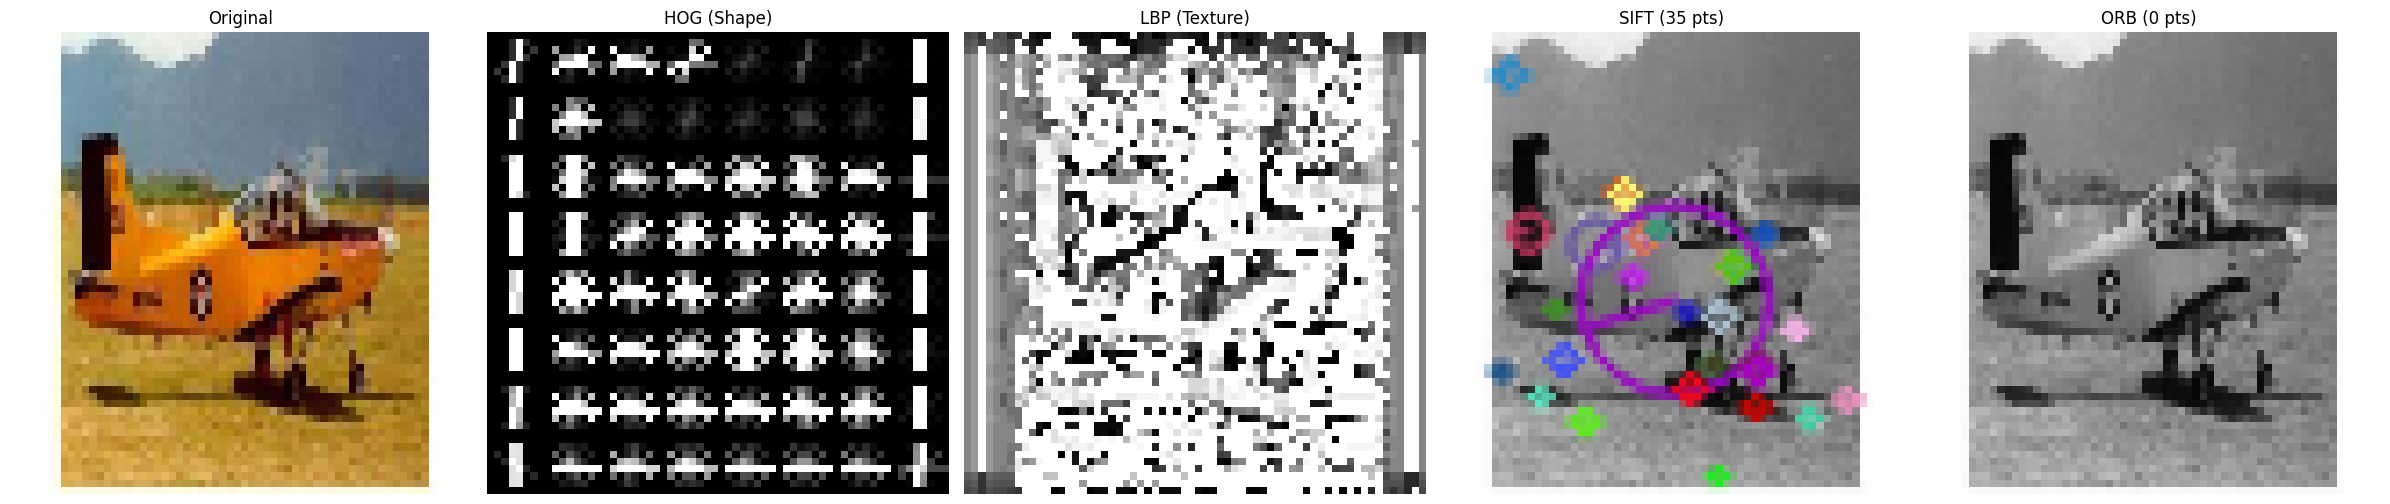

In [ ]:
def visualize_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    fig, axes = plt.subplots(1, 5, figsize=(24, 5))
    
    # 1. Original
    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    # 2. HOG
    _, hog_img = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=True, channel_axis=None)
    axes[1].imshow(exposure.rescale_intensity(hog_img, in_range=(0, 10)), cmap='gray')
    axes[1].set_title("HOG (Shape)")
    axes[1].axis('off')
    
    # 3. LBP (Texture)
    # Radius=3, Points=24 gives robust texture patterns
    lbp = local_binary_pattern(gray, P=24, R=3, method="uniform")
    axes[2].imshow(lbp, cmap='gray')
    axes[2].set_title("LBP (Texture)")
    axes[2].axis('off')
    
    # 4. SIFT Keypoints
    try:
        sift = cv2.SIFT_create()
        kp = sift.detect(gray, None) # None means no mask is used.
        sift_img = cv2.drawKeypoints(gray, kp, None, flags=4) # It draws circles with size (scale) and lines (orientation) rather than just dots.
        axes[3].imshow(sift_img)
        axes[3].set_title(f"SIFT ({len(kp)} pts)")
    except:
        axes[3].text(0.5, 0.5, "SIFT N/A", ha='center')
    axes[3].axis('off')

    # 5. ORB Keypoints
    orb = cv2.ORB_create(nfeatures=300) # nfeatures=300: Limits the detector to find only the top 300 strongest keypoints.
    kp = orb.detect(gray, None)
    orb_img = cv2.drawKeypoints(gray, kp, None, color=(0,255,0), flags=0) # Uses the default drawing method (just small circles indicating location).
    axes[4].imshow(orb_img)
    axes[4].set_title(f"ORB ({len(kp)} pts)")
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run visualization on a random image from the dataset
if len(X_small) > 0:
    sample_idx = np.random.randint(0, len(X_small))
    print(f"Visualizing class: {SMALL_CLASSES[y_small[sample_idx]]}")
    visualize_features(X_small[sample_idx])

### PART 3: TRADITIONAL FEATURE DESCRIPTORS
We will implement the classic Computer Vision pipeline:
1.  **Extract Features:** Using HOG, SIFT, or ORB.
2.  **Flatten/Aggregate:** Convert keypoints to a single vector (Mean Pooling).
3.  **Classify:** Use a Support Vector Machine (SVM).

*Note: SIFT/ORB usually produce variable numbers of keypoints. To make them compatible with SVM, we will average the descriptors for this lab (Mean Pooling).*

In [36]:
class FeatureExtractor:
    def __init__(self):
        self.sift = cv2.SIFT_create()
        self.orb = cv2.ORB_create(nfeatures=100)

    def get_hog(self, img_gray):
        return hog(img_gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), feature_vector=True)

    def get_lbp(self, img_gray, numPoints=24, radius=3):
        # LBP returns an image. We need a histogram (feature vector)
        lbp = local_binary_pattern(img_gray, numPoints, radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3),
                                 range=(0, numPoints + 2))
        # Normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        return hist

    def get_keypoints(self, detector, img_gray):
        kp, des = detector.detectAndCompute(img_gray, None)
        if des is None: 
            return np.zeros((detector.descriptorSize(),))
        return np.mean(des, axis=0) # Mean Pooling

    def extract(self, image, method):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        if method == 'hog': return self.get_hog(gray)
        elif method == 'lbp': return self.get_lbp(gray)
        elif method == 'sift': return self.get_keypoints(self.sift, gray)
        elif method == 'orb': return self.get_keypoints(self.orb, gray)
        else: raise ValueError("Unknown method")

def process_dataset(X_data, method):
    extractor = FeatureExtractor()
    features = []
    print(f"   ...Extracting {method.upper()}...")
    for img in X_data:
        features.append(extractor.extract(img, method))
    return np.array(features)

### PART 4: EXPERIMENTS (TRADITIONAL)

**Experiment 1: Small Scale (4 Classes)**
* Hypothesis: High accuracy. The classes (Planes, Bikes, Faces, Guns) are visually distinct.

**Experiment 2: Medium Scale (20 Classes)**
* Hypothesis: **Performance Drop**. Similar classes (Bear vs Dog, multiple faces) will confuse the descriptors. This is the **Semantic Gap**.


🔬 EXPERIMENT: Small (4 Classes)
   ...Extracting HOG...
HOG Accuray: 98.7%
   ...Extracting SIFT...
SIFT Accuray: 72.7%
   ...Extracting ORB...
ORB Accuray: 22.1%
   ...Extracting LBP...
LBP Accuray: 71.4%


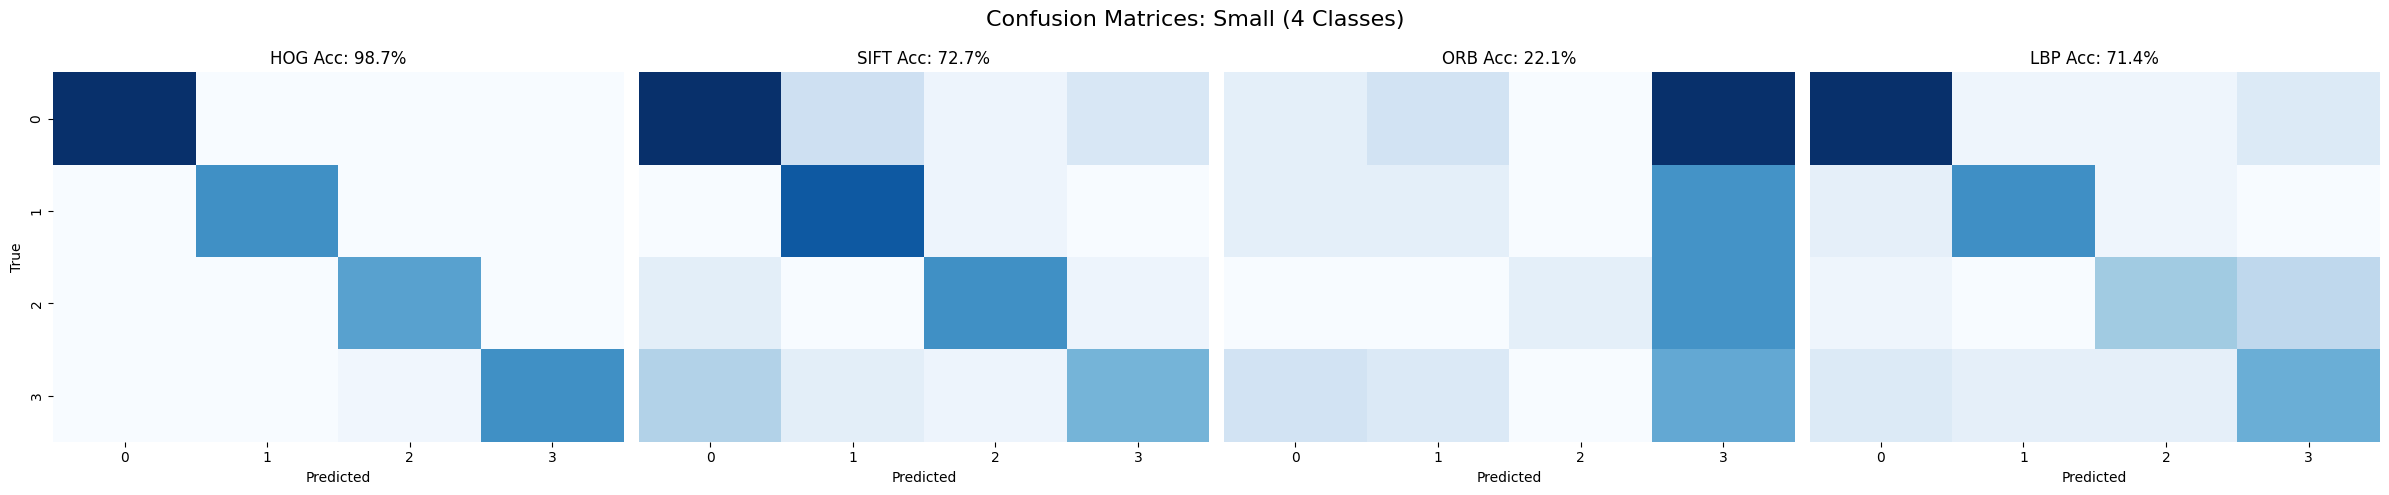


🔬 EXPERIMENT: Medium (20 Classes)
   ...Extracting HOG...
HOG Accuray: 50.9%
   ...Extracting SIFT...
SIFT Accuray: 33.2%
   ...Extracting ORB...
ORB Accuray: 6.1%
   ...Extracting LBP...
LBP Accuray: 36.7%


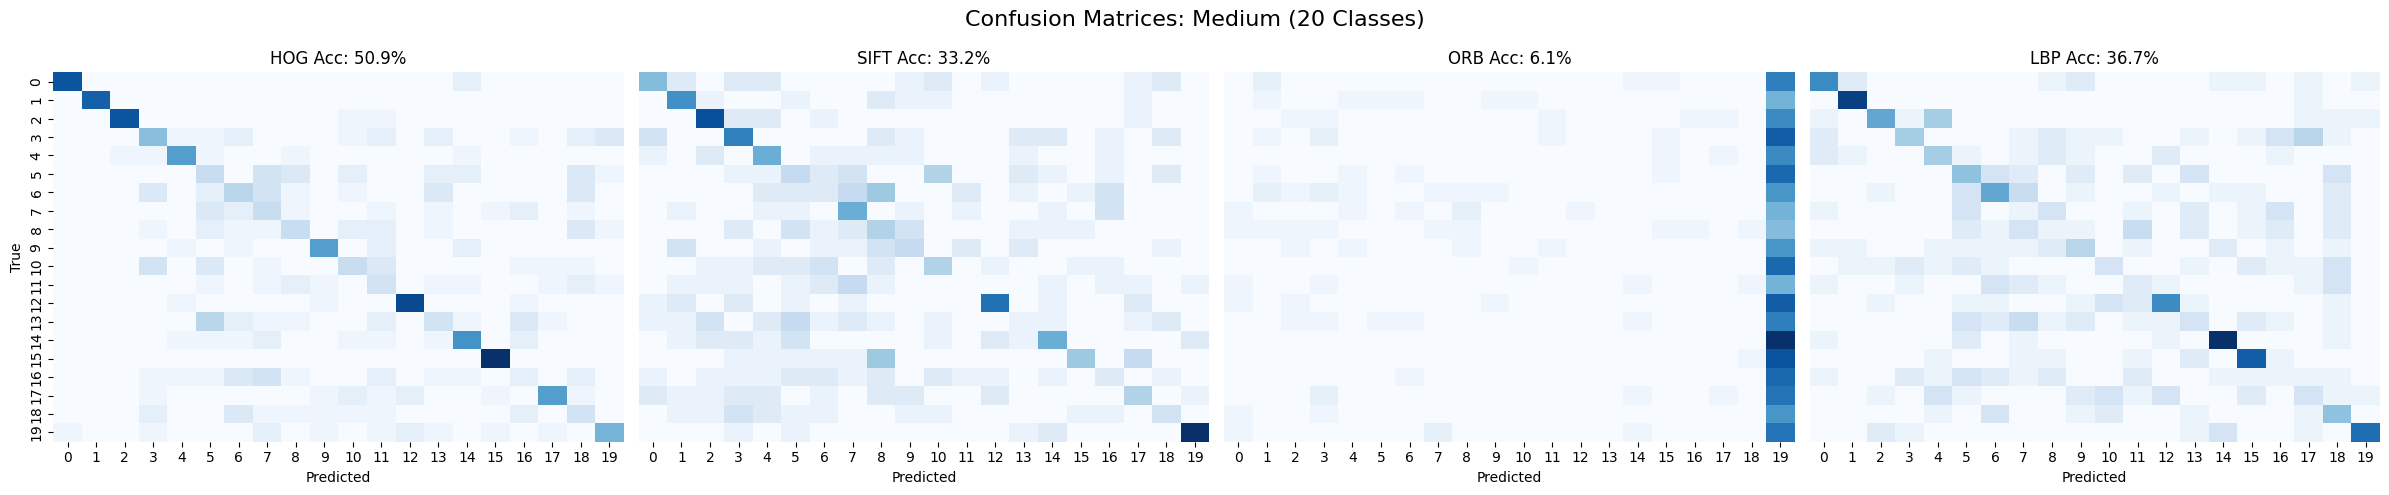

In [43]:
methods = ['hog', 'lbp', 'sift', 'orb']
datasets = {
    'Small': (X_small, y_small, SMALL_CLASSES),
    'Medium': (X_med, y_med, MEDIUM_CLASSES)
}

# Dictionary to store final accuracies
results_history = {'Small': {}, 'Medium': {}}

# --- TRADITIONAL LOOP ---
for ds_name, (X, y, class_names) in datasets.items():
    print(f"\n{'='*40}\n🔬 EXPERIMENT: {ds_name} Scale\n{'='*40}")
    
    # Plot confusion matrices row
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    
    for i, method in enumerate(methods):
        # 1. Extract
        X_feats = process_dataset(X, method)
        
        # 2. Split & Scale
        X_train, X_test, y_train, y_test = train_test_split(X_feats, y, test_size=0.2, random_state=42)
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # 3. Train Classifier
        clf = SVC(kernel='linear', C=1.0)
        clf.fit(X_train, y_train)
        
        # 4. Evaluate
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results_history[ds_name][method] = acc
        
        print(f"✅ {method.upper()} Accuracy: {acc:.2%}")
        
        # 5. Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f"{method.upper()} Acc: {acc:.1%}")
        axes[i].set_xlabel('Predicted')
        if i==0: axes[i].set_ylabel('True')
        else: axes[i].set_yticks([])
    
    plt.suptitle(f"Confusion Matrices: {ds_name} Scale", fontsize=16)
    plt.tight_layout()
    plt.show()

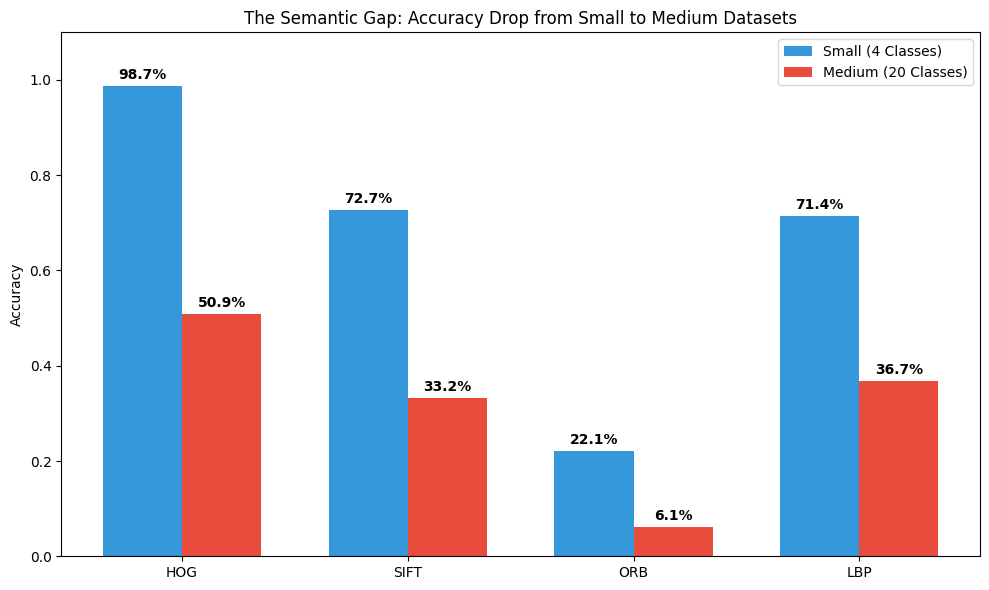

In [44]:
# Prepare data for plotting
x = np.arange(len(methods))
width = 0.35

acc_small = [res[0] for res in final_results.values()]
acc_med = [res[1] for res in final_results.values()]

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, acc_small, width, label='Small (4 Classes)', color='#3498db')
rects2 = ax.bar(x + width/2, acc_med, width, label='Medium (20 Classes)', color='#e74c3c')

ax.set_ylabel('Accuracy')
ax.set_title('The Semantic Gap: Accuracy Drop from Small to Medium Datasets')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in methods])
ax.legend()
ax.set_ylim(0, 1.1)

# Add labels
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

### PART 5: DEEP LEARNING (CNN)
The traditional methods failed to maintain performance on the Medium scale dataset.
We will now use a **Convolutional Neural Network (CNN)**.

**Why CNN?**
* **Hierarchical Learning:** It learns edges -> shapes -> objects automatically.
* **Adaptability:** It optimizes features specifically for our dataset, unlike fixed HOG/SIFT.
* **End-to-End:** The feature extractor and classifier learn together.

In [41]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import callbacks

# --- CNN LOOP (VGG16) ---
def run_cnn(X, y, num_classes):
    # 1. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 2. Dynamically get input shape from the data
    # X.shape is (N, Height, Width, Channels). We need (Height, Width, Channels).
    input_shape = X_train.shape[1:] 
    print(f"   Detected input shape: {input_shape}")

    # 3. Preprocess for VGG16
    # VGG16 expects specific normalization (subtracting mean RGB values)
    X_train_pre = preprocess_input(X_train.copy().astype(float))
    X_test_pre = preprocess_input(X_test.copy().astype(float))
    
    # 4. Load VGG16 (Feature Extractor)
    # We pass the dynamic 'input_shape' here
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False # Freeze base to use as feature extractor
    
    # 5. Add Classifier Head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # 6. Train
    print("   Training CNN...")
    model.fit(X_train_pre, y_train, epochs=8, batch_size=32, verbose=0)
    
    # 7. Evaluate
    loss, acc = model.evaluate(X_test_pre, y_test, verbose=0)
    return acc


print("\n--- TRAINING CNN BASELINES ---")
acc_cnn_small = run_cnn(X_small, y_small, len(SMALL_CLASSES))
results_history['Small']['cnn'] = acc_cnn_small
print(f"CNN Small Accuracy: {acc_cnn_small:.2%}")

acc_cnn_med = run_cnn(X_med, y_med, len(MEDIUM_CLASSES))
results_history['Medium']['cnn'] = acc_cnn_med
print(f"CNN Medium Accuracy: {acc_cnn_med:.2%}")

--- RUNNING SMALL SCALE ---

🚀 Training Transfer Learning (VGG16) for SMALL Scale...
   Detected Image Shape: (64, 64, 3)
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3236 - loss: 12.1315 - val_accuracy: 0.6883 - val_loss: 2.6143
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7283 - loss: 3.5165 - val_accuracy: 0.8701 - val_loss: 0.8379
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8125 - loss: 1.8256 - val_accuracy: 0.9481 - val_loss: 0.3611
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8952 - loss: 0.9276 - val_accuracy: 0.9221 - val_loss: 0.4113
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9068 - loss: 0.5841 - val_accuracy: 0.9351 - val_loss: 0.4383
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9138 - loss: 0.7147 - val_accuracy: 0.9481 - val_loss: 0.3781
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9045 - loss: 0.5949 - val_accuracy: 0.9481 - val_l

### PART 6: THE BIG PICTURE
Let's compare Traditional Descriptors vs. CNNs side-by-side.

**What to look for:**
1.  **The Drop:** How much did Traditional methods drop when we went from 4 to 20 classes?
2.  **The Bridge:** Did the CNN drop *less* than the traditional methods?

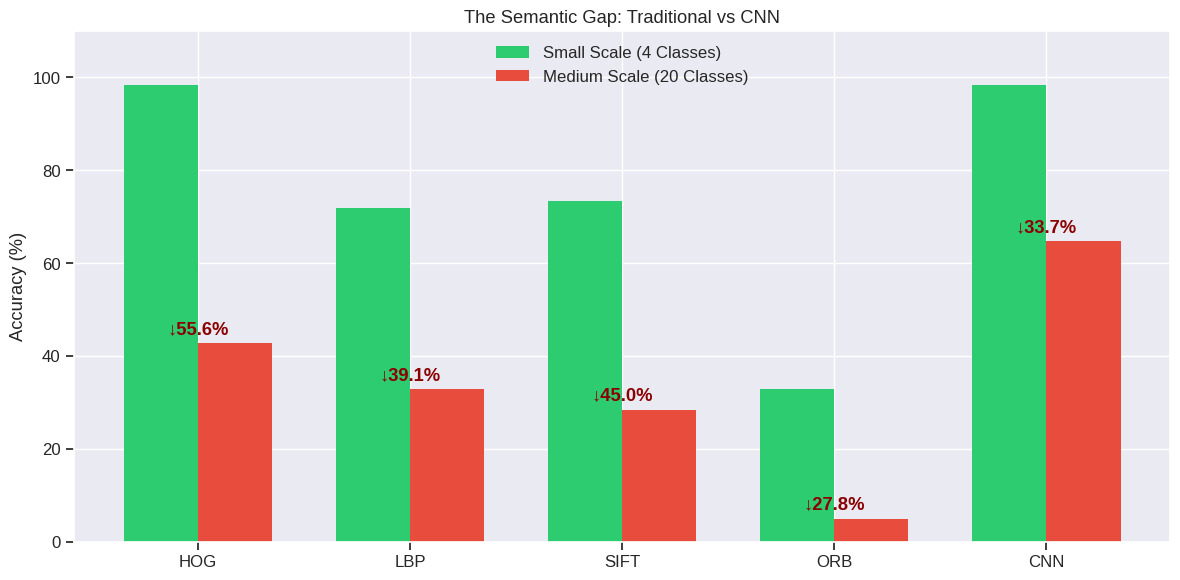


📊 FINAL ANALYSIS:
HOG Drop: 55.6%
CNN Drop: 33.7%
Interpretation: The CNN maintained performance better because it learned SEMANTIC features!


In [59]:
# Aggregate Results
methods_all = methods + ['cnn']
accs_small = [results_history['Small'][m] * 100 for m in methods] + [acc_cnn_small * 100]
accs_med = [results_history['Medium'][m] * 100 for m in methods] + [acc_cnn_med * 100]

# Visualization
x = np.arange(len(methods_all))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, accs_small, width, label='Small Scale (4 Classes)', color='#2ecc71')
rects2 = ax.bar(x + width/2, accs_med, width, label='Medium Scale (20 Classes)', color='#e74c3c')

ax.set_ylabel('Accuracy (%)')
ax.set_title('The Semantic Gap: Traditional vs CNN')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in methods_all])
ax.legend()
ax.set_ylim(0, 110)

# Add Drop Labels
for i in range(len(methods_all)):
    drop = accs_small[i] - accs_med[i]
    ax.text(x[i], accs_med[i] + 2, f'↓{drop:.1f}%', ha='center', fontweight='bold', color='darkred')

plt.tight_layout()
plt.show()

print("\n📊 FINAL ANALYSIS:")
print(f"HOG Drop: {accs_small[0] - accs_med[0]:.1f}%")
print(f"CNN Drop: {accs_small[-1] - accs_med[-1]:.1f}%")
print("Interpretation: The CNN maintained performance better because it learned SEMANTIC features!")

### PART 7: INSIDE THE BLACK BOX
Finally, let's visualize the feature maps of our trained CNN to see the hierarchy in action.
* **Layer 1:** Should look like edges/colors (similar to HOG).
* **Layer 2:** Textures and patterns.
* **Layer 3:** Abstract parts of objects.


🔍 Visualizing VGG16 Learned Features...


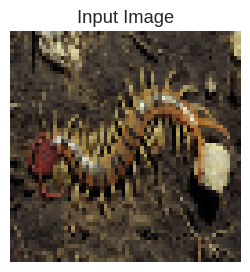

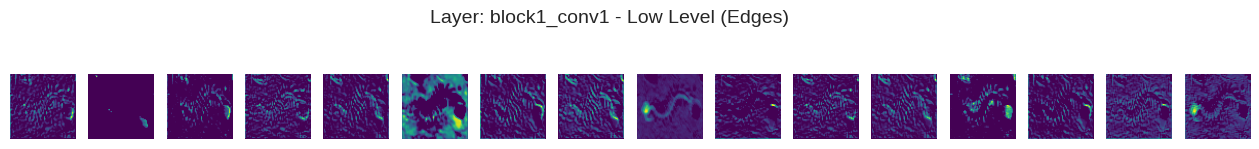

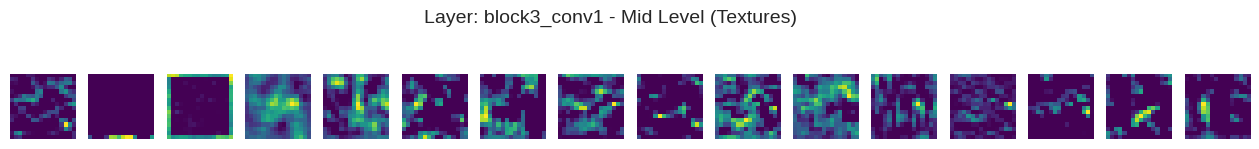

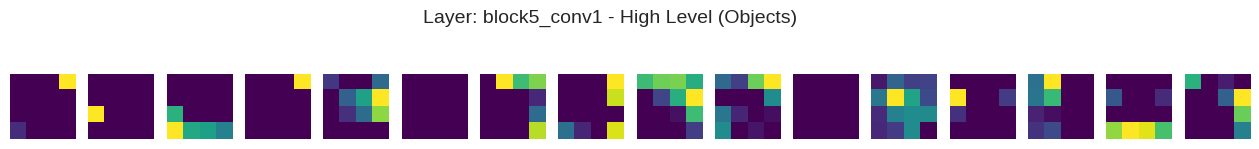


✨ LAB COMPLETE: You have successfully bridged the Semantic Gap!


In [61]:
# ======================================================
# 7. INSIDE THE BLACK BOX: VISUALIZING VGG16 FEATURES
# ======================================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

def visualize_vgg_features(img):
    """
    Visualizes feature maps from specific layers of VGG16.
    """
    # 1. Prepare the image
    # VGG16 expects images, so we use the dynamic shape of the image itself
    target_size = img.shape[:2] # (Height, Width)
    img_tensor = np.expand_dims(img, axis=0) # Add batch dimension: (1, H, W, 3)
    img_tensor = preprocess_input(img_tensor.copy().astype(float)) # Normalize colors
    
    # 2. Load VGG16 Base (Pre-trained on ImageNet)
    # This contains the "eyes" of the network (filters)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
    
    # 3. Define layers to inspect
    # block1_conv1: Detects simple edges/colors
    # block3_conv1: Detects textures/patterns
    # block5_conv1: Detects complex object parts
    layer_names = ['block1_conv1', 'block3_conv1', 'block5_conv1']
    layer_descriptions = ["Low Level (Edges)", "Mid Level (Textures)", "High Level (Objects)"]
    
    # Create a model that outputs these specific layers
    outputs = [base_model.get_layer(name).output for name in layer_names]
    feature_model = Model(inputs=base_model.input, outputs=outputs)
    
    # 4. Get Activations
    activations = feature_model.predict(img_tensor, verbose=0)
    
    # 5. Plotting
    for i, activation in enumerate(activations):
        n_filters = 16 # Number of filters to show
        plt.figure(figsize=(16, 2))
        
        for f in range(n_filters):
            if f < activation.shape[-1]:
                plt.subplot(1, n_filters, f+1)
                # Show the f-th filter map
                plt.imshow(activation[0, :, :, f], cmap='viridis')
                plt.axis('off')
        
        plt.suptitle(f"Layer: {layer_names[i]} - {layer_descriptions[i]}", fontsize=14)
        plt.show()

print("\n🔍 Visualizing VGG16 Learned Features...")

# 1. Select a REAL image from the loaded dataset (not X_test)
# We use X_med because it contains the raw image data
if len(X_med) > 0:
    # Pick a random image
    sample_idx = np.random.randint(0, len(X_med))
    sample_image = X_med[sample_idx]

    # Show the original input image
    plt.figure(figsize=(3,3))
    plt.imshow(sample_image)
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    # Run visualization
    visualize_vgg_features(sample_image)
else:
    print("⚠️ Error: X_med dataset is empty. Please run the Data Loading step first.")

print("\n✨ LAB COMPLETE: You have successfully bridged the Semantic Gap!")